# DBN Structure Inference

The idea is to infer a posterior for the *structure* of a Dynamic Bayesian Network (DBN), given some data.

We formulate this task with the following model:

$$ P(G | X) \propto P(X | G) \cdot P(G) $$

* $P(G)$ is a prior distribution over DBN structures. We'll assume it has the form
$$P(G) \propto \exp \left( -\lambda |G \setminus G^\prime| \right)$$
where $|G \setminus G^\prime|$ denotes the number of edges in the graph, which are not present in some reference graph $G^\prime$.
* $P(X | G)$ is the marginal likelihood of the DBN structure. That is, it's the likelihood of the DBN after the network parameters have been integrated out -- it scores network *structure*. 
* If we assume some reasonable priors for network parameters, $P(X|G)$ can be obtained in closed form. In this work, we'll use the following marginal likelihood:
    
    $$P(X | G) \propto \prod_{i=1}^p (1 + n)^{-(2^{|\pi(i)|} - 1)/2} \left( X_i^{+ T} X_i^+ - \frac{n}{n+1} X_i^{+ T} B_i (B_i^T B_i)^{-1} B_i^T X_i^+ \right)^{-\frac{n}{2}}$$ 
    where $X$ and $B$ are matrices obtained from data. This marginal likelihood results from an empirical prior over the regression coefficients, and an improper ($\propto 1/\sigma^2$) prior for the regression "noise" variables.

In [1]:
include("DiGraph.jl")
using Gen
using Plots
Plots.pyplot()
using .DiGraphs
using LinearAlgebra
using CSV
using DataFrames
using LRUCache

## Get some data

For now, we'll work with some data used by Hill et al. in their 2007 paper, _Bayesian Inference of Signaling Network Topology in a Cancer Cell Line_.

It gives the differential phosphorylation levels of 20 proteins, in a cancer cell line perturbed by EGF. This is a well-studied signaling pathway; the goal is to produce a graph describing the dependencies between proteins in this pathway. 

In [2]:
protein_names = CSV.read("data/protein_names.csv");
reference_adjacency = CSV.read("data/prior_graph.csv");
timesteps = CSV.read("data/time.csv");
timeseries_data = CSV.read("data/mukherjee_data.csv");

## Build the model

Implement the graph prior distribution:

$$P(G) \propto \exp \left( -\lambda |G \setminus G^\prime| \right)$$

In [3]:
struct GraphPrior <: Gen.Distribution{DiGraph} end
const graphprior = GraphPrior()

Gen.random(gp::GraphPrior, lambda::Float64, reference_graph::DiGraph) = reference_graph

function graph_edge_diff(g::DiGraph, g_ref::DiGraph)
    e1 = Set([g.edges[i,:] for i=1:size(g.edges)[1]])
    e_ref = Set([g_ref.edges[i,:] for i=1:size(g_ref.edges)[1]])
    return length(setdiff(e1, e_ref))
end
    
Gen.logpdf(gp::GraphPrior, graph::DiGraph, lambda::Float64, reference_graph::DiGraph) = -lambda * graph_edge_diff(graph, reference_graph)

graphprior(lambda::Float64, reference_graph::DiGraph) = Gen.random(graphprior, lambda, reference_graph);

Implement the DBN's marginal distribution:

$$P(X | G) \propto \prod_{i=1}^p (1 + n)^{-(2^{|\pi(i)|} - 1)/2} \left( X_i^{+ T} X_i^+ - \frac{n}{n+1} X_i^{+ T} B_i (B_i^T B_i)^{-1} B_i^T X_i^+ \right)^{-\frac{n}{2}}$$

Some things to note:
* We're kind of shoe-horning this marginal likelihood into Gen. The probabilistic programming ethos entails modeling the entire data-generating process. This ought to provide better performance during inference, though.

In [4]:
struct DBNMarginal <: Gen.Distribution{Array{Float64,3}} end
const dbnmarginal = DBNMarginal()

"""
DBNMarginal's sampling method does nothing.
In our inference task, the Xs will always be observed.
"""
Gen.random(dbn::DBNMarginal, parents::Vec{Vec{Int}}, T::Int) = zeros(length(parents), T)

function compute_B(idx::Tuple{Vararg{Int64,N} where N}, dataset::Array{Array{Float64,2},1},
                   B_cache::Dict{Tuple{Vararg{Int64,N} where N}, Array{Float64,2}})

function compute_lp_term(X::Array{Float64,2}, dataset::Array{Array{Float64,2},1}, i::Int, T::Int, parents::Array{Int,1},
                         lp_cache::Dict{Tuple{Vararg{Int64,N} where N}, Float64},
                         B_cache::Dict{Tuple{Vararg{Int64,N} where N}})

    # Check whether the term has already been computed:
    k = (i, parents...)
    if k in keys(lp_cache)
        return lp_cache[k]
    else
        
        x_plus = X[i,2:T]
        x_minus = X[i,1:T-1]
        B = compute_B()
        
        matprod = pinv(dot(transpose(B), B))
        
        cache[k] = -0.5*size(B)[2]*log(1.0+N) -  0.5*N*log(dot(transpose(x_plus), x_plus) - (n/(n+1.0))*t
        
end
    
"""
DBNMarginal's log_pdf, in effect, returns a score for the 
network topology. We use a dictionary to cache precomputed terms of the sum.
"""
function Gen.log_pdf(dbn::DBNMarginal, X::Array{Float64,3}, parents::Vec{Vec{Int}}, 
                     cache::Dict{Tuple{Int,Vararg{Int64,N} where N},Float64})
    
    
end

UndefVarError: UndefVarError: Vec not defined

Implement a DBN:

In [5]:
@gen function dbn_node(x_prev::Vec{Float64}, parents::Vec{Int}, weights::Vec{Float}, noise::Float64)
    x_new = @trace(Gen.normal(dot()), :x)
    return x_new
end

layer_nodes = Gen.Map(dbn_node)

@gen function dbn_layer(timestep::Int, x_prev::Vec{Float64}, parents::Vec{Vec{Int}}, weights::Vec{Vec{Float64}})
    x_prev_repeat = fill(x_prev, length(parents))
    x_new = @trace(layer_nodes(x_prev_repeat, parents, weights), :variables)
    return x_new
end
    
dbn = Gen.Unfold(dbn_layer)

independent_series = Gen.Map(unfolded_layers)

@gen function dbn(V::Vec{Int}, parents::Vec{Vec{Int}}, T::Int)
    
    x = @trace(unfolded_layers(), :timeseries)
    return x
end

UndefVarError: UndefVarError: Vec not defined

Implement our overall model:

In [6]:
function get_parent_vecs(G)
    return [sort(in_neighbors(G, v)) for v in sort(G.vertices)]
end
    
@gen function coeff_prior()

@gen function data_generator(X::Vec{Array{Float64,2}}, reference_graph::DiGraph{Int}, Tvec::Vec{Int})
    
    lambda = @trace(Gen.gamma(1,1), :lambda)
    
    G = @trace(GraphPrior(lambda, reference_graph), :G)
    V = sort(G.vertices)
    parents = get_parent_vecs(G)
    
    x_init = @trace(Gen.mvnormal(), :x_init)
    regression_coeffs = @trace(, :beta)
    regression_noise = @trace(, :noise)
    
    x = @trace(dbn(V, parents, ))

LoadError: syntax: unexpected ","

## Inference

### Metropolis-Hastings over directed graphs

Proposal distribution:

In [7]:
"""
Proposal distribution for exploring the unconstrained space of
directed graphs.

`expected_indegree` guides the exploration -- if a vertex's in-degree
is higher than this, then we are much more likely to remove an edge
from one of its parents.
"""
@gen function digraph_proposal(tr, expected_indegree::Float64)
    
    G = copy(tr[:G])
    ordered_vertices = sort(collect(G.vertices))
    V = length(G.vertices)
    
    u_idx = @trace(Gen.uniform_discrete(1,V), :u_idx)
    u = ordered_vertices[u_idx]
    ordered_inneighbors = sort(collect(in_neighbors(G,u)))
    in_deg = length(ordered_inneighbors)
    
    prob_remove = (1.0*in_deg / V) ^ log2(1.0*V / expected_indegree)
    remove_edge = @trace(Gen.bernoulli(prob_remove), :remove_edge)
    
    if remove_edge
        v_idx = @trace(Gen.uniform_discrete(1, in_deg), :v_idx)
        v = ordered_inneighbors[v_idx]
        remove_edge!(G, v, u)
    else
        
        outneighbors = out_neighbors(G,u)
        ordered_exc_outneighbors = sort(collect(setdiff(outneighbors, ordered_inneighbors)))
        out_exc_deg = length(ordered_exc_outneighbors)
        deg = length(union(outneighbors, ordered_inneighbors))
        
        prob_reverse = 1.0 * out_exc_deg / deg
        reverse_edge = @trace(Gen.bernoulli(prob_reverse), :reverse_edge)
        if reverse_edge
            
            v_idx = @trace(Gen.uniform_discrete(1, out_exc_deg), :v_idx)
            v = ordered_exc_outneighbors[v_idx]
            remove_edge!(G, u, v)
            add_edge!(G, v, u)
        else
            nonparents = sort(collect(setdiff(G.vertices, ordered_inneighbors)))
            len = length(nonparents)
            v_idx = @trace(Gen.uniform_discrete(1,len), :v_idx)
            v = nonparents[v_idx]
            add_edge!(G, v, u)
        end
        
    end
    
    return G
    
end;

Involution function:

In [8]:
function digraph_involution(cur_tr, fwd_choices, fwd_ret, prop_args)
    
    # Update the trace 
    new_G = fwd_ret
    old_G = cur_tr[:G]
    update_choices = Gen.choicemap()
    update_choices[:G] = new_G
    new_tr, weight, retdiff, discard = Gen.update(cur_tr, Gen.get_args(cur_tr), (), update_choices)
    
    # figure out what has changed
    fwd_u_idx = fwd_choices[:u_idx]
    sorted_vertices = sort(collect(old_G.vertices))
    fwd_u = sorted_vertices[fwd_u_idx]
    fwd_v_idx = fwd_choices[:v_idx]
    
    # Deduce the correct backward choices
    bwd_choices = Gen.choicemap()
    if fwd_choices[:remove_edge] # an edge was removed -- we must add it back.
        
        fwd_parents = collect(in_neighbors(old_G, fwd_u))
        fwd_v = sort(fwd_parents)[fwd_v_idx]
        bwd_nonparents = sort(collect(setdiff(new_G.vertices,in_neighbors(new_G, fwd_u))))
        bwd_v_idx = indexin([fwd_v], bwd_nonparents)[1]
        
        bwd_choices[:u_idx] = fwd_u_idx 
        bwd_choices[:remove_edge] = false
        bwd_choices[:reverse_edge] = false
        bwd_choices[:v_idx] = bwd_v_idx
        
    else
        if fwd_choices[:reverse_edge] # an edge was reversed -- reverse it back.
            
            fwd_exc_outneighbors = sort(collect(setdiff(out_neighbors(old_G, fwd_u), in_neighbors(old_G, fwd_u))))
            fwd_v = fwd_exc_outneighbors[fwd_v_idx]
            bwd_u_idx = indexin([fwd_v], sorted_vertices)[1]
            bwd_exc_outneighbors = sort(collect(setdiff(out_neighbors(new_G, fwd_v), in_neighbors(new_G, fwd_v))))
            bwd_v_idx = indexin([fwd_u], bwd_exc_outneighbors)[1]
            
            bwd_choices[:u_idx] = bwd_u_idx
            bwd_choices[:remove_edge] = false
            bwd_choices[:reverse_edge] = true
            bwd_choices[:v_idx] = bwd_v_idx
            
        else # an edge was added -- remove it.
            
            fwd_nonparents = sort(collect(setdiff(old_G.vertices, in_neighbors(old_G, fwd_u))))
            fwd_v = fwd_nonparents[fwd_v_idx]
            bwd_parents = sort(collect(in_neighbors(new_G, fwd_u)))
            bwd_v_idx = indexin([fwd_v], bwd_parents)[1]
            
            bwd_choices[:u_idx] = fwd_u_idx
            bwd_choices[:remove_edge] = true
            bwd_choices[:v_idx] = bwd_v_idx
            
        end
    end
    
    return new_tr, bwd_choices, weight
end;

Let's this proposal and make sure it's behaving reasonably.

There's a one-to-one mapping between (i) directed graphs and (ii) bipartite undirected graphs. We'll visualize our directed graphs as follows:

In [9]:
function visualize_digraph(dg::DiGraph)
    v = sort(collect(dg.vertices))
    ys = length(v):-1:1
    y_dict = Dict([vert => ys[i] for (i,vert) in enumerate(v)])
    xs = [1.0, length(v)]
    
    p = Plots.plot(xlim=(0.0, length(v)+1), ylim=(0.0, length(v)+1), 
    legend=false, framestyle=:none, aspect_ratio=0.75)
    Plots.yticks!(p, ys, v)
    
    for i=1:size(dg.edges)[1]
        e = dg.edges[i,:]
        Plots.plot!(p, xs, [y_dict[e[1]]; y_dict[e[2]]], c=:black)
    end
    for j=1:length(v)
        Plots.scatter!(p, xs, [y_dict[v[j]]; y_dict[v[j]]], markersize=20, markercolor=:gray)
        Plots.annotate!(p, xs, [y_dict[v[j]]; y_dict[v[j]]], v[j])
    end
    
    return p
end
        

visualize_digraph (generic function with 1 method)

In [10]:
ref_graph = DiGraph(["a" "b"; "a" "c"; "b" "c"])

DiGraph{String}(Set(["c", "b", "a"]), ["a" "b"; "a" "c"; "b" "c"])

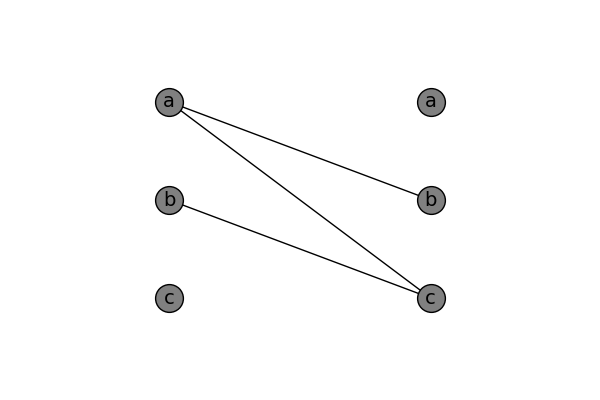

In [11]:
visualize_digraph(ref_graph)

In [24]:
function animate_digraph_sampling(dg::DiGraph, model, proposal, proposal_args, involution, n_iterations)
   
    tr, _ = Gen.generate(model, ())
    anim = @animate for i=1:n_iterations
        tr, _ = Gen.metropolis_hastings(tr, proposal, proposal_args, involution)
        p = visualize_digraph(tr[:G])
        Plots.title!(p, "DBN Architecture: $(i) steps")
    end every 10
    gif(anim)
    
end

animate_digraph_sampling (generic function with 1 method)

In [25]:
@gen function dumb_model()
    @trace(graphprior(1.0, ref_graph), :G)
    return
end

DynamicDSLFunction{Any}(Dict{Symbol,Any}(), Dict{Symbol,Any}(), Type[], ##dumb_model#2080, Bool[], false)

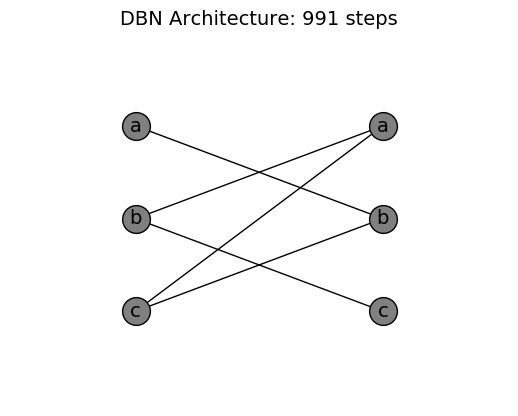

┌ Info: Saved animation to 
│   fn = /home/dmerrell/projects/graph-ppl/julia-project/tmp.gif
└ @ Plots /home/dmerrell/.julia/packages/Plots/Iuc9S/src/animation.jl:95


In [26]:
animate_digraph_sampling(ref_graph, dumb_model, digraph_proposal, (1.0,), digraph_involution, 1000);